# Neural Networks for Sequence Data

This notebook demonstrates an easy wasy to train a Neural Network (NN) on DNA data, 
make predictions for Transcription Factor Binding Sites (TFBS) and extract the learned motif with a simple gradient-based method.

We will take a collection of sequences plus information if they are bound by a transcription factor as input data and after training a convolutional neural network we will be able to make predictions for new sequences. In addition we will extract what the network learned and make a plot of the motif.

The examples are chosen such that it is not necessary to have a GPU and should learn just fine on a CPU.

## Load Necessary Libraries

In [15]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Flatten

from keras.models import Sequential

import numpy as np
from sklearn.metrics import roc_curve, auc, average_precision_score

from helper import IOHelper, SequenceHelper

import random
random.seed(1234)

## Load the sequence data

There are two example files available `data/ctcf.fa.gz` and `data/pu1.fa.gz`

In [31]:
input_fasta_data = IOHelper.get_fastas_from_file("data/pu1.fa.gz", uppercase=True)
sequence_length = len(input_fasta_data.sequence[0])
seq_matrix = SequenceHelper.do_one_hot_encoding(input_fasta_data.sequence, sequence_length,
                                                SequenceHelper.parse_alpha_to_seq)

In [45]:
print("Sample Sequence:", input_fasta_data.sequence[0])
print("Sequence length:", sequence_length)
print("One hot encoded sequence:")
print(seq_matrix[0])

Sample Sequence: AGCCCTGAGCTGACTCACTGATTAGCTTTCTCAAAAAGAGGAAGTGAGGACAGTGAATAAGTGGGTTCTCTTGGTTCAGAGCTGGAGCCCACTCACGTTT
Sequence length: 100
One hot encoded sequence:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0.

The negative data is generated by shuffling the positive data

In [48]:
# Helper Function that creates the negative set of examples
# by shuffling the positive examles
def do_dinucleotide_shuffling(X, size=1):
    x_shuffled = np.repeat(X, size, 0)

    for x in range(0, x_shuffled.shape[0]):
        random_index = np.arange(0, int(X.shape[1]/2))
        np.random.shuffle(random_index)
        for y in range(0, int(X.shape[1]/2)):
            x_shuffled[x,y*2, ] = X[int(x%X.shape[0]),random_index[y]*2]
            x_shuffled[x,(y*2)+1, ] = X[int(x%X.shape[0]),(random_index[y]*2)+1]

    return x_shuffled

seq_shuffled = do_dinucleotide_shuffling(np.array([[[e] for e in list(x)] for x in input_fasta_data.sequence]), size=1)
seq_shuffled = np.array(["".join(seq_shuffled[x, :, 0]) for x in range(seq_shuffled.shape[0])])
seq_shuffled_matrix = SequenceHelper.do_one_hot_encoding(seq_shuffled, sequence_length,
                                                         SequenceHelper.parse_alpha_to_seq)

## Create the Neurol Network Architecture

We start with a fairly simple NN architeture of a single convolutional layer followed by a max-pooling layer
and then a single dense layer.

In [49]:
print("Sample negative example:", seq_shuffled[0])

Sample negative example: ATGTCCACGAAGCCTGGGTCGCGTACGCCAGTTGGATTTCATGAGCAAGCTCGACATGGGTCAGGATTTCTGGTAGTTTCAGAAACTTGAACCTTAAGAA


In [50]:
model = Sequential()
model.add(Conv2D(16, (12, 4), padding='valid', input_shape=(100, 4, 1),
                        activation='relu'))

model.add(MaxPooling2D(pool_size=(15,1), padding='valid'))

model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='sgd')

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 89, 1, 16)         784       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 1, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2592      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 3,409
Trainable params: 3,409
Non-trainable params: 0
_________________________________________________________________


## Create a test and a training subset

To have a reasonable estimate of the training, the data is split into a training (80%) and a test (20%) set.

In [52]:
# Create a random index
shuffling_index = np.arange(seq_matrix.shape[0] + seq_shuffled_matrix.shape[0])
np.random.shuffle(shuffling_index)

# Full data set Y ~ X where Y is a vector of 0s and 1s and X is the 
# corresponding sequence data
X = np.concatenate((seq_matrix, seq_shuffled_matrix))[shuffling_index, :, :]
X = np.nan_to_num(X)
Y = np.concatenate((np.ones(seq_matrix.shape[0]), np.zeros(seq_shuffled_matrix.shape[0])))[shuffling_index]

# Splitting the data into a training and a test set
X_train = X[0:int(X.shape[0]*0.8), :, :]
Y_train = Y[0:int(X.shape[0]*0.8)]

X_test = X[int(X.shape[0]*0.8):X.shape[0], :, :]
Y_test = Y[int(X.shape[0]*0.8):X.shape[0]]

#print(X_train.shape)
#print( Y_train.shape)

In [53]:
# Reshaping the data so it corresponds to the input format of keras
# Keras is developed for image analysis so the 1 basically means 1 color channel
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

print("Training data size:", X_train_reshaped.shape)
print("Testing data size", X_test_reshaped.shape)

Training data size: (45883, 100, 4, 1)
Testing data size (11471, 100, 4, 1)


## Fit the Model

The NN is trained with the training set for 25 epochs. The test set is used to assess the actual training success after each epoch.

This step can take a few minutes.

In [59]:
# You can play around with the batch_size, increasing it means that more examples are propagated 
# through the network at once
# epochs sets the number of full data iterations
model.fit(X_train_reshaped, Y_train,
          batch_size=10000, epochs=25,
          validation_data=(X_test_reshaped, Y_test))


Train on 45883 samples, validate on 11471 samples
Epoch 1/25
45883/45883 [==============================] - 0s 6us/step - loss: 0.0587 - val_loss: 0.0648
Epoch 2/25
45883/45883 [==============================] - 0s 2us/step - loss: 0.0587 - val_loss: 0.0648
Epoch 3/25
45883/45883 [==============================] - 0s 2us/step - loss: 0.0587 - val_loss: 0.0648
Epoch 4/25
45883/45883 [==============================] - 0s 2us/step - loss: 0.0587 - val_loss: 0.0648
Epoch 5/25
45883/45883 [==============================] - 0s 2us/step - loss: 0.0587 - val_loss: 0.0648
Epoch 6/25
45883/45883 [==============================] - 0s 2us/step - loss: 0.0587 - val_loss: 0.0648
Epoch 7/25
45883/45883 [==============================] - 0s 3us/step - loss: 0.0587 - val_loss: 0.0648
Epoch 8/25
45883/45883 [==============================] - 0s 2us/step - loss: 0.0587 - val_loss: 0.0647
Epoch 9/25
45883/45883 [==============================] - 0s 2us/step - loss: 0.0587 - val_loss: 0.0647
Epoch 10/25
45

## Evaluating the Model

After the NN was trained the test set is used to calculate the [AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and [AUPRC](https://en.wikipedia.org/wiki/Precision_and_recall) (different combinations of the number of true and false predictions).

In [60]:
# The predictions are between 0 and 1 because of the sigmoid activation
# function of the last layer in the NN
pred = model.predict(X_test_reshaped, batch_size=32).flatten()
print("Predictions", pred[0:5])

# We can also calculate the AUC to get an estimate how good the NN actually learned
fpr, tpr, thresholds = roc_curve(Y_test, pred)
print("AUC", auc(fpr, tpr))
print("AUPRC", average_precision_score(Y_test, pred))

Predictions [0.22738817 0.85545206 0.96188915 0.95719725 0.95561826]
AUC 0.9711337244562476
AUPRC 0.9711984223264862


## Make a motif plot:

In [61]:
# Plot the motif for the sequences 0 to 4
plot_index = range(0, 5)

# Get the Y ~ X for the sequences we want to plot
seq_matrix_for_plotting = seq_matrix.reshape((seq_matrix.shape[0], seq_matrix.shape[1], seq_matrix.shape[2], 1))[plot_index, :]
plotting_pred = model.predict(seq_matrix_for_plotting, batch_size=32).flatten()

#### Calculate Gradient

In [62]:
# Generate a new set of X where for each sequence every nucleotide is consecutively set to 0
tmp = np.repeat(seq_matrix_for_plotting, 100, axis=0)

a = np.ones((100, 100), int)
np.fill_diagonal(a, 0)
b = np.repeat(a.reshape((1,100,100)), seq_matrix_for_plotting.shape[0], axis=0)
c = np.concatenate(b, axis=0)
d = np.multiply(tmp, np.repeat(c.reshape((tmp.shape[0], 100, 1, 1)), 4, axis=2))

print(seq_matrix_for_plotting.shape)
print(d.shape)

(5, 100, 4, 1)
(500, 100, 4, 1)


In [63]:
# Calculate the prediction for each sequence with one deleted nucleotide
d_pred = model.predict(d, batch_size=32).flatten()

# Score: Difference between prediction and d_pred
scores = np.reshape((np.repeat(plotting_pred, 100) - d_pred), (len(plot_index),100))

# Score: Ratio between (1-d_pred) and (1-prediction)
# scores = np.reshape((1-d_pred)/(1-np.repeat(plotting_pred, 100))-1, (len(plot_index),100))

# Many more possibilities to calculate the score
# scores = ...

#### Make the Actual Plot

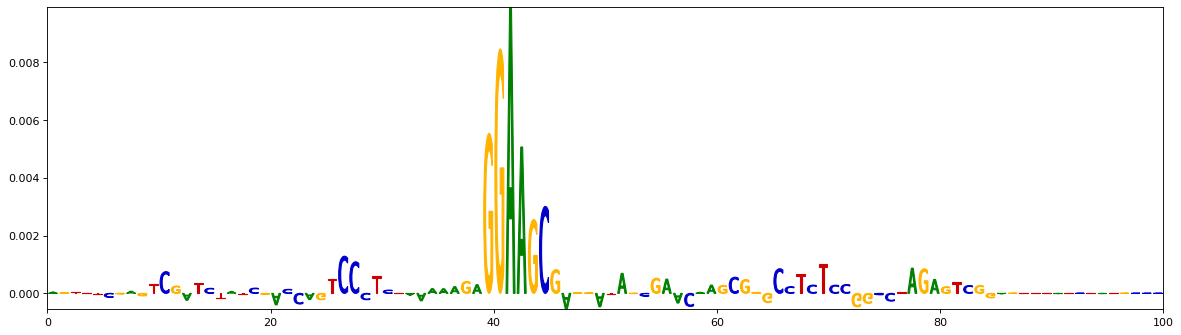

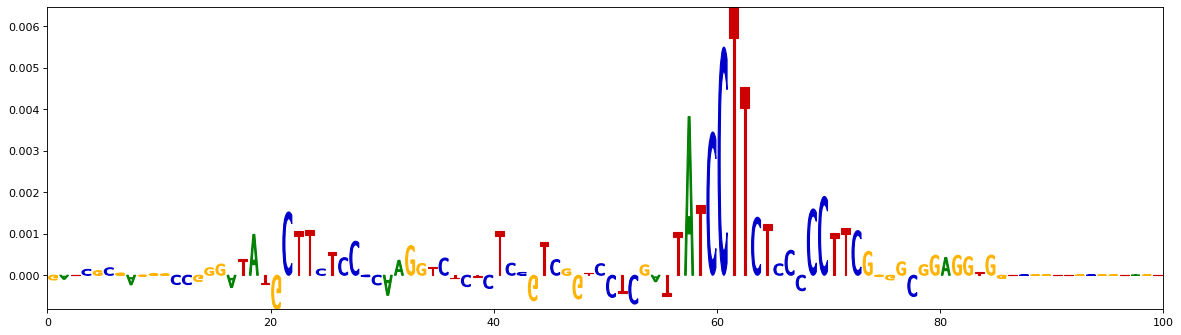

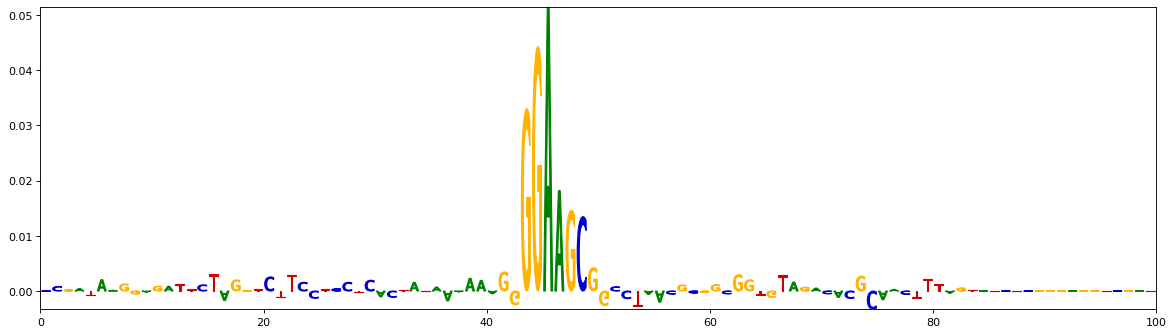

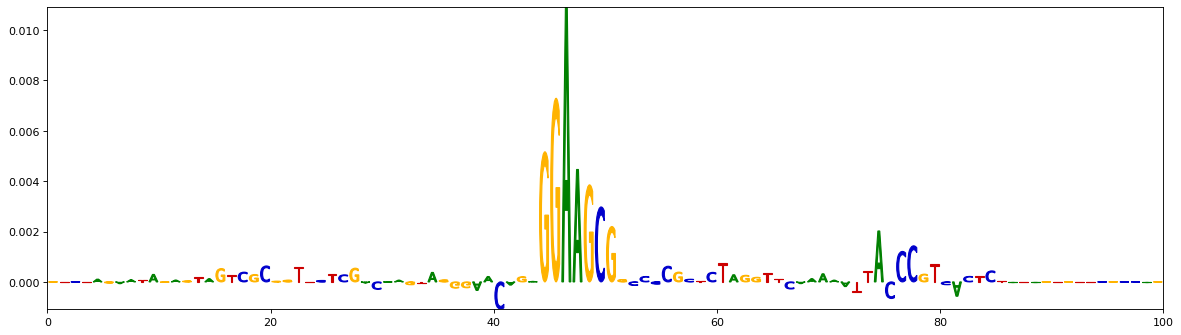

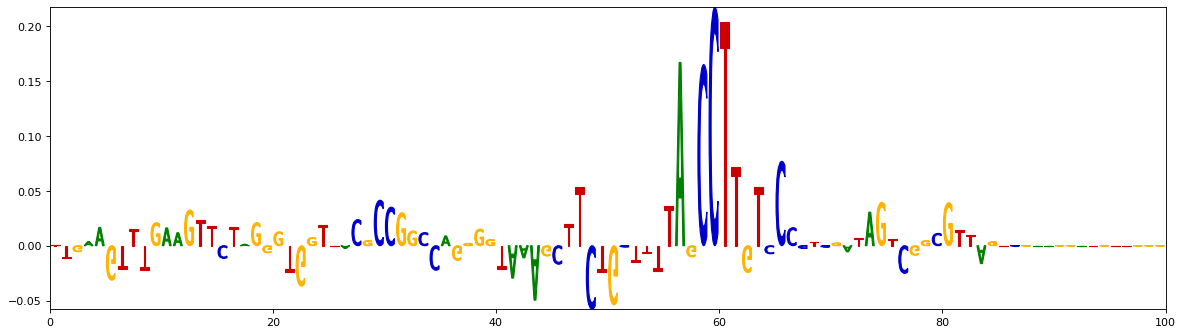

In [64]:
%matplotlib inline

import motif_plotter
import matplotlib.pyplot as plt

for idx in range(0,len(plot_index)):
    fig=plt.figure(figsize=(18, 5), dpi= 80)
    ax=fig.add_subplot(111)
    motif_plotter.make_single_sequence_spectrum(ax, 
                                                seq_matrix_for_plotting[idx].reshape((100, 4)),
                                                np.arcsinh(scores[idx]).reshape(100,1))
    plt.show()
